## Lab 3

### Part 2. Almost Shakespeare (2.0 points)

В этой части задания мы научимся генерировать текст с помощью нейронных сетей. Конкретнее, обучим нейронную сеть на сонетах Шекспира и попросим нейросеть написать свой сонет.

Генерация текста обычно включает в себя следующие шаги:
    
1. Загрузка данных.
2. Создание словарей слов/символов.
3. Препроцессинг данных.
4. Обучение модели (нейросети).
5. Генерация нового текста.


#### Часть 1. Предобработка данных

Для начала загрузим данные. Файл с сонетами Шекспира доступен по [ссылке](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). Кроме того, он находится рядом с этим ноутбуком (`sonnetes.txt`).

Базовая предобработка уже сделана: текст состоит непосредственно из поэм Шекспира и названий/номеров глав, все техническая информация удалена.

In [ ]:
import string

In [ ]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
  
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

Так как в этот раз мы хотим научиться предсказывать текст, понизим сложность задачи и приведем текст к нижнему регистру.

В настоящий момент переменная `text` представляет собой список из строк. Объедините все строки в одну и приведите к нижнему регистру. 

In [ ]:
# Объедините все строки в одну и приведите к нижнему регистру.
# Результат запишите в переменную text.
import numpy as np

res = ''
print(type(res))
for line in text:
  res += line
text = res.lower()



assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('Отлично!')

<class 'str'>
Отлично!


Выделите множество всех символов, с которыми нам довелось встретиться в переменную `tokens`.

In [ ]:
tokens = sorted(set(text))

Постройте словарь `token_to_idx` вида <символ>: <индекс> и словарь `idx_to_token` вида <индекс>: <символ>.

In [ ]:
# словарь вида <индекс>:<символ>
token_to_idx = {}
i = 0
for symbol in tokens:
  token_to_idx[symbol] = i
  i += 1

# словарь вида <символ>:<индекс>
idx_to_token = {y:x for x,y in token_to_idx.items()}

num_tokens = len(tokens) 

*Комментарий: т.к. у нас всего 38 различных токенов, в этот раз воспользуемся one-hot encoding'ом.*


## Построение модели.

Теперь наша задача - создать и обучить рекуррентную нейронную сеть, которая сможет генерировать что-то похожее на поэзию Шекспира.

Для начала воспользуемся классической RNN, аналогичной построенной на семинаре. 

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())

In [ ]:
seq_size=32
batch_size=16


idx_text = [token_to_idx[w] for w in text]
num_batches = len(idx_text) // (seq_size * batch_size)
in_text = idx_text[:num_batches * batch_size * seq_size]
out_text = np.zeros_like(in_text)
out_text[:-1] = in_text[1:]
out_text[-1] = in_text[0]

in_text = np.reshape(in_text, (batch_size, -1))
out_text = np.reshape(out_text, (batch_size, -1))

In [ ]:
in_text = torch.LongTensor(in_text)
logp_seq = model(in_text)

loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens), 
                  in_text[:, :-1].contiguous().view(-1))

loss.backward()

In [ ]:
in_text.size()

torch.Size([16, 6240])

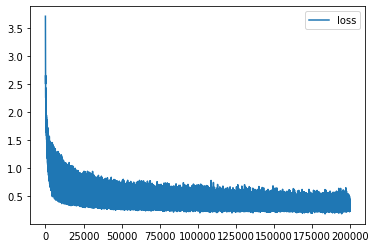

In [ ]:
history = []
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(200000):
    i = random.randint(0, num_batches)
    batch_ix = in_text[:, i:i+seq_size]
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    # print(batch_ix.size())
    logp_seq = model(batch_ix)


    
    # compute loss

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    
    
    # train with backprop

    logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

    loss = -logp_next.mean()
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()
        torch.save(model.state_dict(), 'model.pth')
        torch.save(opt.state_dict(), 'optimizer.pth')

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Постройте график функции потерь в зависимости от номера эпохи.

In [ ]:
# Пример сгенерированного текста. Функция `generate_text` отсутствует в коде выше. Реализуйте ее самостоятельно.
# print(generate_text(length=500, temperature=0.2))

In [ ]:
def generate_text(length, initial = ' ', temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in initial]
    
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).unsqueeze(0)
    #print( x_sequence.data.numpy()[0])


    #start generating
    for _ in range(length):


        # NOTE THAT  x_sequence[ :, -1] is NOT the last symbol, it's the whole sequence
        # u can easily check it with print fuction
        # it is used to reduce dimention


        logp_next = model(x_sequence[ :, -1])
        #print( x_sequence.data.numpy()[0]) 
        #print( x_sequence[ :, -1].data.numpy()[0]) 
        
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0][-1]

        #print(str(p_next)+ '\n' )
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p = p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        #print( x_sequence.data.numpy()[0]) 
        x_sequence = torch.cat([x_sequence[:, -1], next_ix], dim=1)
        x_sequence = x_sequence.unsqueeze(0)
    
    #print( x_sequence.data.numpy()[0]) 
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [ ]:
generate_text(length=500)

" may, yet not directly th praintond in of thy praise thee?\n  even for this shall have xvi\n\n  thin the se healter heir mind:\n  shall hate be fairer lodg'd than gentle lovery'sprogn,\n  when beauty lived and deen my will beautiful old rime,\n  in praise of ladies dead and lovely knights,\n  then, in the blazon of sweet beauty's best,\n  of hand, of everyoot, of holth not both to evel,\n  within the gentle closure of lade,  of at,\n  ecoue thiners beauty's but being both from me, in the blazon of sweet be"

### Более поэтичная модель

Теперь давайте воспользуемся LSTM слоем вместо классической RNN и сравним результаты.

Снова постройте график функции потерь от числа эпох. Стал ли финальный loss лучше?

In [ ]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.lstm(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
model = CharLSTMLoop()
opt = torch.optim.Adam(model.parameters())

In [ ]:
seq_size=32
batch_size=16


idx_text = [token_to_idx[w] for w in text]
num_batches = len(idx_text) // (seq_size * batch_size)
in_text = idx_text[:num_batches * batch_size * seq_size]
out_text = np.zeros_like(in_text)
out_text[:-1] = in_text[1:]
out_text[-1] = in_text[0]

in_text = np.reshape(in_text, (batch_size, -1))
out_text = np.reshape(out_text, (batch_size, -1))

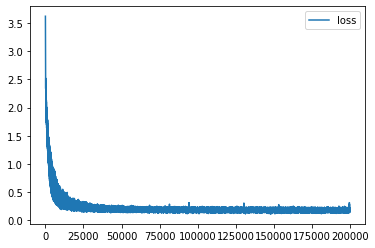

In [ ]:
history = []
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(200000):
    i = random.randint(0, num_batches)
    batch_ix = in_text[:, i:i+seq_size]
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    # print(batch_ix.size())
    logp_seq = model(batch_ix)


    
    # compute loss

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    
    
    # train with backprop

    logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

    loss = -logp_next.mean()
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()
        torch.save(model.state_dict(), 'model_lstm.pth')
        torch.save(opt.state_dict(), 'optimizer_lstm.pth')

assert np.mean(history[:10]) > np.mean(history[-10:]), "LSTM didn't converge."

Видим по графику, что лосс стал  меньше, также он убывает гораздо быстрее, чем в случае RNN. Можно было обучать меньшее число эпох, т.к. лосс вышел на стационарынй уровень на ~ 75000 итерации.

Сгенерируйте текст с помощью обученной сети для различных значений параметра `temperature`: `[0.1, 0.2, 0.5, 1.0, 2.0]` ("температуры" при генерации). Оцените результаты визуально, попробуйте их проинтерпретировать.

In [ ]:
generate_text(length=500)

[[ 1 14 29 16 12 31 32 29 16 30  1 34 16  1 15 16 30 20 29 16  1 20 25 14
  29 16 12 30 16  6  0  1  1 31 19 12 31  1 31 19 16 29 16 13 36  1 13 16
  12 32 31 36  3 30  1 29 26 30 16  1 24 20 18 19 31  1 25 16 33 16 29  1
  15 20 16  6  0  1  1 13 32 31  1 12 30  1 31 19 16  1 29 20 27 16 29  1
  30 19 26 32 23 15  1 13 36  1 31 20 24 16  1 15 16 14 16 12 30 16  6  0
   1  1 19 20 30  1 31 16 25 15 16 29  1 19 16 20 29  1 24 20 18 19 31  1
  13 16 12 29  1 19 20 30  1 24 16 24 26 29 36  9  0  1  1 13 32 31  1 31
  19 26 32  6  1 14 26 25 31 29 12 14 31 16 15  1 31 26  1 31 19 20 25 16
   1 26 34 25  1 13 29 20 18 19 31  1 16 36 16 30  6  0  1  1 17 29 26 24
   1 34 19 16 25 14 16  1 12 31  1 27 23 16 12 30 32 29 16  1 31 19 26 32
   1 24 12 36 30 31  1 14 26 24 16  1 12 25 15  1 27 12 29 31  1 26 17  1
  24 16 11  0  1  1 34 19 12 31  1 14 12 25  1 24 20 25 16  1 26 34 25  1
  27 29 12 20 30 16  1 31 26  1 24 20 25 16  1 26 34 25  1 30 16 23 17  1
  13 29 20 25 18 11  0  1  1 12 25 15 

" creatures we desire increase,\n  that thereby beauty's rose might never die,\n  but as the riper should by time decease,\n  his tender heir might bear his memory:\n  but thou, contracted to thine own bright eyes,\n  from whence at pleasure thou mayst come and part of me?\n  what can mine own praise to mine own self bring?\n  and what is'd thee are all determinate.\n  for how do i hold thee but by thy granting?\n  and for that riches where is my deserving?\n  the cause of this fair gift;\n  but not directly"

Сгенерированный текст стал более осмысленным, практически не осталось ошибок в словах, при желании можно даже найти какой-то смысл:)


In [ ]:
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
  print('temperature =' + str(temp) + '\n' + str(generate_text(length=500, temperature = temp)) + '\n')
  print('__________________________________________________________')

temperature =0.1
 thou lead away,
  if thou wouldst use the strength of all thy state!
    but do not so; i love thee in such sort,
    as, thou being mine, mine is thy good report.

  xcvii

  hefut neter part of me?
  what can mine own praise to mine own self bring?
  and what is't but mine own when i praise thee?
  even for this, let us divided live,
  and our dear lovel deter at being at your beck,
  the imprison'd absence of your least;
  yet in these thoughts my self almost despising,
  haply i think on the

__________________________________________________________
temperature =0.2
 the prey of every vulgar thief.
  thee have i not lock'd up in any chest,
  save where thou art not, though i feel thou art,
  within the gentle closure of my breast,
  from whence at pleasure thou mayst come and part of me?
  what can mine own praise to mine own self bring?
  and what is't but mine own when i praise thee?
  even for this, let us divided live,
  and our dear love will is noth any com


*   LSTM работает лучше обычной CNN
*   Чем больше температура, тем больше случайность. Поэтому при temp = 2.0, текст уже перестает быть понятным, некоторые слова хоть и похожи на настоящие, но таковыми не являются.
*   При temp = 1  получилось самое осмысленное стихотворение
*   Из-за того, что в датасете была нумерация страниц, модели генерят и ее.
*   Работу моих CNN и LSTM можно ускорить: не обрабатовать последовательность на каждой итерации, а выдавать и передавать на следущую итерацию хидден. Тогда можно подавать лишь последний элемент последовательности (вместе с хидденом). 

### Сделаем LSTM с передаей хиденна.



In [ ]:
class CharLSTMLoop_hidden(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.hidden_dim = rnn_num_units
        
    def forward(self, x, hidden):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, hidden = self.lstm(self.emb(x), hidden)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden 
        

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(1, batch_size, self.hidden_dim).zero_(),
                      weight.new(1, batch_size, self.hidden_dim).zero_())
        return hidden
    
model = CharLSTMLoop_hidden()
opt = torch.optim.Adam(model.parameters())

In [ ]:
seq_size=32
batch_size=16


idx_text = [token_to_idx[w] for w in text]
num_batches = len(idx_text) // (seq_size * batch_size)
in_text = idx_text[:num_batches * batch_size * seq_size]
out_text = np.zeros_like(in_text)
out_text[:-1] = in_text[1:]
out_text[-1] = in_text[0]

in_text = np.reshape(in_text, (batch_size, -1))
out_text = np.reshape(out_text, (batch_size, -1))


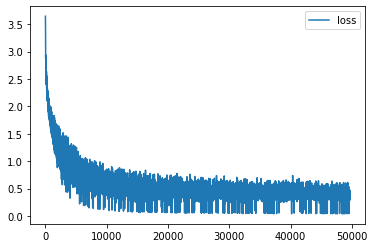

In [ ]:
history = []
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

h = model.init_hidden(batch_size)
for i in range(50000):
    i = random.randint(0, num_batches)
    batch_ix = in_text[:, i:i+seq_size]
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    # print(batch_ix.size())
    #h.detach_()
    h = tuple([e.data for e in h])


    logp_seq, h = model(batch_ix, h)


    
    # compute loss

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    
    
    # train with backprop

    logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

    loss = -logp_next.mean()
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()
        torch.save(model.state_dict(), 'model_lstm_hidden.pth')
        torch.save(opt.state_dict(), 'optimizer_lstm_hidden.pth')

assert np.mean(history[:10]) > np.mean(history[-10:]), "LSTM didn't converge."

In [ ]:
def generate_text_hidden(length, initial = ' ', temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in initial]
    
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).unsqueeze(0)
    
    h = model.init_hidden(1)

    #start generating
    for _ in range(length):

        #________________________________
        # NOTE THAT  x_sequence[ :, :, -1] IS the last symbol of the sequence
        # u can easily check it with print fuction
        #________________________________

        h = tuple([e.data for e in h])

        logp_next, h = model(x_sequence[ :, :, -1], h)
       
        #print( x_sequence[ :, :, -1].data.numpy()) 
        
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0][-1]

        #print(str(p_next)+ '\n' )
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p = p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
 
        x_sequence = torch.cat([x_sequence[:, -1], next_ix], dim=1)
        x_sequence = x_sequence.unsqueeze(0)
        #print('_______END_OF_CURRENT_ITER_____________')
    
    
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [ ]:
generate_text_hidden(length = 500)

" i not rost despe,\n  but do not so; in swhee i  i  art not, though i feel thou art,\n  within the gentle closure of my bre is my deserving?\n  then my state,\n  like to the lark at blazon ofour,\n  hand the account of hours to crack,\n  the imprison'd wivef lip, of eyt,\n  or to thyself at least kind-hearted prove:\n    make thee another self bring?\n  and what is't but mine own when i praise thee?\n  even fi hold bue may i sing,\n  hand spacious,\n  notod let us dom me, both to each friend,\n  i guess one a"

По ощущуениям стало работать быстрее. 

К сожалению, не усе

#### Сохранение и загрузка модели

Сохраните обученную модель на диск, затем загрузите ее и сгенерируйте текст. Примеры доступны по [ссылке](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

Заметим, что я сохраняю модель на каждом тесте. Загрузим RNN из первого пункта лабы и сгенерируем текст с помощью этой модели. 

In [ ]:
model = CharRNNLoop()
model.load_state_dict(torch.load('/content/model.pth'))
model.eval()

generate_text(length=500)

" shalt chis.\n\n  lxviind\n  those children nursed, deliver'd from thy brain,\n  to take a new acquaintance of thy mind.\n\n   but do not so; i love thee in such sort,\n    no; let me suffer, being at your beck,\n  the imprison'd abs thy progk on thee,-- and then my state,\n  like to the lark at break of day arising\n  no; your tich still doth grow?\n\n  cxvi\n\n  this, gracious and kind,\n  or to thyself arncinds ilh an of thy to live,\n  lip, of eye, of brow,\n  i should pain,\n  wart,\n  sut nuty vand thut hish "

Данная часть задания завершена.

#### Полезные ссылки
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Статья Андрея Карпатого про RNN. </a> В качестве примеров рассматриваются задачи генерации Шекспировских текстов, Latex формул, Linux Source Code и детских имен.
2. <a href='https://github.com/karpathy/char-rnn'> Репозиторий с кодом по char-rnn </a> (тоже за авторством Андрея Карпатого)
3. Полезный репозиторий по PyTorch: [ссылка](https://github.com/spro/practical-pytorch`)